In [1]:
import os
import json
import imageio
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import transforms

from lib import utils, tri_dvgo_multiscene

Using /home/hydeng/.cache/torch_extensions as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/hydeng/.cache/torch_extensions/adam_upd_cuda/build.ninja...
Building extension module adam_upd_cuda...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
ninja: no work to do.
Loading extension module adam_upd_cuda...
Using /home/hydeng/.cache/torch_extensions as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/hydeng/.cache/torch_extensions/render_utils_cuda/build.ninja...
Building extension module render_utils_cuda...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
ninja: no work to do.
Loading extension module render_utils_cuda...


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
model_class = tri_dvgo_multiscene.DirectVoxGO
# ckpt_path = 'logs/tri_dvgo_multiscene/nerf_synthetic/rnd_liif_posemb_conv_down1/fine_last.tar'
ckpt_path = 'logs/tri_dvgo_multiscene/nerf_synthetic/3conv_liif_pretrain_down4/fine_last.tar'
# ckpt_path = 'logs/tri_dvgo_multiscene/nerf_synthetic/3conv_liif_pretrain_down4_cosine/fine_last.tar'
# ckpt_path = 'logs/tri_dvgo_multiscene/nerf_synthetic/3conv_liif_pretrain_down4_cosine_featunfold/fine_330000.tar'

# ckpt_path = 'logs/tri_dvgo_multiscene/nerf_synthetic/3MLP_liif_pretrain_down4/fine_last.tar'
# ckpt_path = 'logs/tri_dvgo_multiscene/nerf_synthetic/MLP_liif_pretrain_down4/fine_last.tar'

In [4]:
model = utils.load_model(model_class, ckpt_path)

initialized encoder networks
{'xy': Conv_Mapping(
  (body): Sequential(
    (0): ResBlock(
      (body): Sequential(
        (0): Conv2d(80, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(80, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (1): ResBlock(
      (body): Sequential(
        (0): Conv2d(80, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(80, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (2): ResBlock(
      (body): Sequential(
        (0): Conv2d(80, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(80, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (3): ResBlock(
      (body): Sequential(
        (0): Conv2d(80, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(80, 8

In [5]:
def read_image(path):
    image = imageio.imread(path)
    image = (np.array(image) / 255.).astype(np.float32)
    if image.shape[-1] == 4:
        image = image[...,:3]*image[...,-1:] + (1.-image[...,-1:])
    return image

In [6]:
def read_poses(path, idxs):
    with open(path, 'r') as f:
        meta = json.load(f)
    poses = []
    for id in idxs:
        frame = meta['frames'][id]
        poses.append(np.array(frame['transform_matrix']))
    poses = np.stack(poses)
    return poses

In [7]:
imagedir = 'data/nerf_synthetic/lego/train'
json_path = 'data/nerf_synthetic/lego/transforms_train.json'
idxs = [34, 49, 63]

images = []
for id in idxs:
    path = os.path.join(imagedir, f'r_{id}.png')
    images.append(read_image(path))
images = np.stack(images)

poses = read_poses(json_path, idxs)

images = torch.FloatTensor(images)
poses = torch.FloatTensor(poses)

In [8]:
print(images.shape, poses.shape)

torch.Size([3, 800, 800, 3]) torch.Size([3, 4, 4])


In [9]:
images = images.permute(0, 3, 1, 2)
h, w = images.shape[-2:]
h, w = h // 4, w // 4
resize = transforms.Resize([h, w])
images = resize(images)
images = (images - 0.5) / 0.5

In [10]:
mapped_feats, feats, _, _, = model.encode_feat(images, poses)

tensor(False)


In [11]:
backbone_feats = model.backbone_encode(images)

In [12]:
print(backbone_feats.shape)

torch.Size([3, 64, 200, 200])


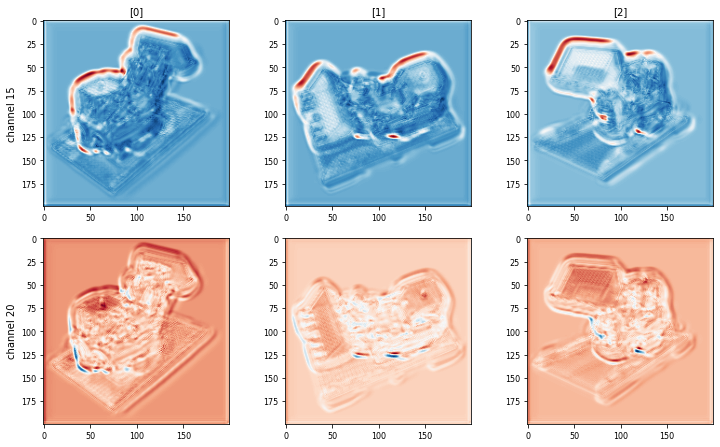

In [13]:
splits = [[0],[1],[2]]
channels = [15, 20]
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12,8))
plt.subplots_adjust(left=None,bottom=None,right=None,top=None,wspace=0.3, hspace=0)
vmin, vmax = 1e6, -1e6
for i, s in enumerate(splits):
    backbone_feats[s] = (backbone_feats[s] - backbone_feats[s].min()) / (backbone_feats[s].max() - backbone_feats[s].min())
    
    vmin = min(backbone_feats[s].min().item(), vmin)
    vmax = max(backbone_feats[s].max().item(), vmax)

for i, channel in enumerate(channels):
    for j, s in enumerate(splits):
        axes[i, j].imshow(backbone_feats[s][0][channel].detach().numpy(), cmap='RdBu')
        axes[i, j].xaxis.set_tick_params(labelsize=8)
        axes[i, j].yaxis.set_tick_params(labelsize=8)

rows = [f'channel {i}' for i in channels]
cols = splits
for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, rotation=90, fontsize=10)

for ax, col in zip(axes[0], cols):
    ax.set_title(col, fontsize=10)

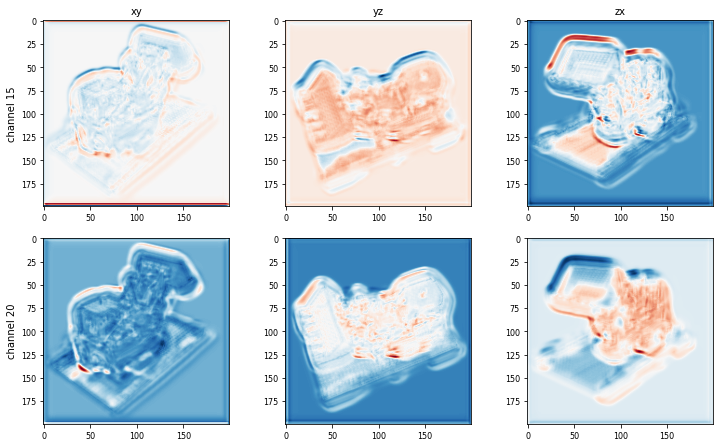

In [14]:
splits = ['xy', 'yz', 'zx']
channels = [15, 20]
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12,8))
plt.subplots_adjust(left=None,bottom=None,right=None,top=None,wspace=0.3, hspace=0)
vmin, vmax = 1e6, -1e6
for i, s in enumerate(splits):
    feats[s] = (feats[s] - feats[s].min()) / (feats[s].max() - feats[s].min())
    
    vmin = min(feats[s].min().item(), vmin)
    vmax = max(feats[s].max().item(), vmax)

for i, channel in enumerate(channels):
    for j, s in enumerate(splits):
        axes[i, j].imshow(feats[s][0][channel].detach().numpy(), cmap='RdBu')
        axes[i, j].xaxis.set_tick_params(labelsize=8)
        axes[i, j].yaxis.set_tick_params(labelsize=8)

rows = [f'channel {i}' for i in channels]
cols = splits
for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, rotation=90, fontsize=10)

for ax, col in zip(axes[0], cols):
    ax.set_title(col, fontsize=10)

In [15]:
print(torch.cosine_similarity(feats['xy'][0][:, 0, 0].unsqueeze(0), feats['yz'][0][:, 0, 0].unsqueeze(0)))

tensor([0.9967], grad_fn=<DivBackward0>)


In [16]:
print(feats['xy'][0][:, 0, 0].shape)

torch.Size([32])


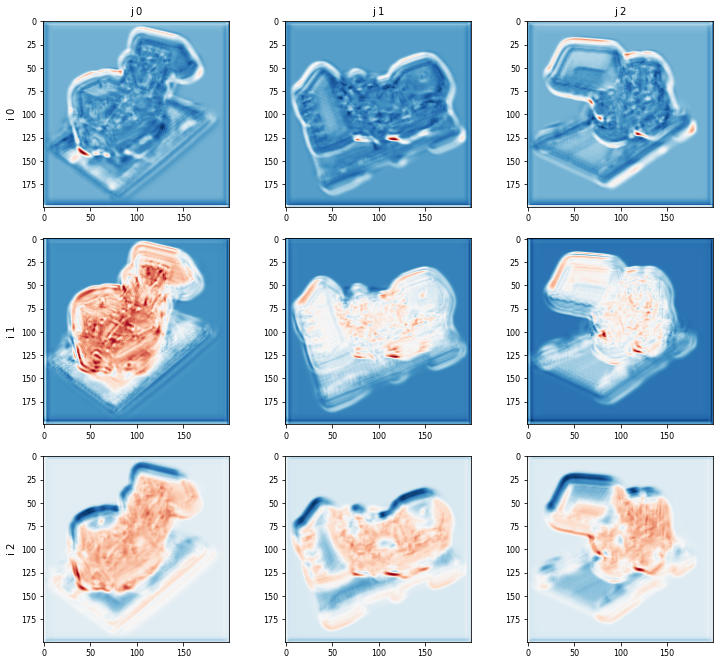

In [18]:
channels = 15
splits = [0, 1, 2]
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12,12))
plt.subplots_adjust(left=None,bottom=None,right=None,top=None,wspace=0.3, hspace=0)
vmin, vmax = 1e6, -1e6
for i in splits:
    for j in splits:
        mapped_feats[i, j] = (mapped_feats[i, j] - mapped_feats[i, j].min()) / (mapped_feats[i, j].max() - mapped_feats[i, j].min())
    
    vmin = min(mapped_feats[i, j].min().item(), vmin)
    vmax = max(mapped_feats[i, j].max().item(), vmax)

for i in splits:
    for j in splits:
        axes[i, j].imshow(mapped_feats[i, j][channel].detach().numpy(), cmap='RdBu')
        axes[i, j].xaxis.set_tick_params(labelsize=8)
        axes[i, j].yaxis.set_tick_params(labelsize=8)

rows = [f'i {i}' for i in splits]
cols = [f'j {i}' for i in splits]
for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, rotation=90, fontsize=10)

for ax, col in zip(axes[0], cols):
    ax.set_title(col, fontsize=10)

In [19]:
print(((mapped_feats[0, 0] - mapped_feats[0, 1])*(mapped_feats[0, 0] - mapped_feats[0, 1])).sum())

tensor(1331.8574, grad_fn=<SumBackward0>)
